In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import RobustScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

properati = pd.read_csv('datos/caba_para_mapa.csv',error_bad_lines=False)

<IPython.core.display.Javascript object>

In [68]:
properati.info()
properati=properati.loc[properati.price_aprox_usd<1e6]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48323 entries, 0 to 48322
Data columns (total 26 columns):
created_on                    48323 non-null object
property_type                 48323 non-null object
place_name                    48323 non-null object
state_name                    48323 non-null object
lat-lon                       48323 non-null object
lat                           48323 non-null float64
lon                           48323 non-null float64
price                         48323 non-null float64
currency                      48323 non-null object
price_aprox_local_currency    48323 non-null float64
price_aprox_usd               48323 non-null float64
surface_total_in_m2           48323 non-null float64
surface_covered_in_m2         48323 non-null float64
price_usd_per_m2              48323 non-null float64
price_per_m2                  48323 non-null float64
floor                         6223 non-null float64
rooms                         33792 non-null float

In [69]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]

In [70]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['place_name']
le_barrio.fit(barrios)
properati['place_name'] = le_barrio.transform(barrios)

le_divisa = preprocessing.LabelEncoder()
divisa=properati['currency']
le_divisa.fit(divisa)
properati['currency'] = le_divisa.transform(divisa)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

In [71]:
scaler= RobustScaler()

# RF Clasificador Casas

In [ ]:
#preparo set de datos
X = zip(properati['dist_a_subte'],properati['dist_a_univ'],properati['dist_a_tren'],properati['dist_a_villa'],\
        properati['dist_a_zona_anegada'],properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'])

y = properati['categories_by_price']

### Busco hiper-parametros con random search

In [ ]:
%%notify

rf = RandomForestClassifier(n_jobs=-1)

oob_score=[True,False]
criterion = ['gini','entropy']
max_features =["auto","log2",None]
n_estimators = np.arange(10,100,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators,"oob_score":oob_score}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=5) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

In [ ]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

In [ ]:
search.score(X_test,y_test) # pruebo el estimador refiteado con el set de test

# RF Regresor

In [81]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati["dist_a_tren"],\
        properati["dist_a_subte"])
y = properati['price_aprox_usd']
X=scaler.fit_transform(X,y)

In [34]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=50) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

### Hago GS en los mejores

In [82]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['log2']
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=5) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 183.50 segundos para 19 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.982 (std: 0.000)
Promedio validation score: 0.876 (std: 0.004)
Promedio fit time: 2.371s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 170, 'criterion': 'mse'}

Puesto: 2
Promedio training score: 0.981 (std: 0.000)
Promedio validation score: 0.876 (std: 0.004)
Promedio fit time: 1.940s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 140, 'criterion': 'mse'}

Puesto: 3
Promedio training score: 0.982 (std: 0.000)
Promedio validation score: 0.876 (std: 0.004)
Promedio fit time: 2.049s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 150, 'criterion': 'mse'}

Puesto: 4
Promedio training score: 0.982 (std: 0.000)
Promedio validation score: 0.876 (std: 0.004)
Promedio fit time: 2.626s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 190, 'criterion': 'mse'}

Puesto: 5
Promedio training score: 0.982 (std: 0.000)
Promedio validation score: 0

<IPython.core.display.Javascript object>

In [83]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.33444766  0.40338112  0.12640299  0.06894555  0.06682267]


In [84]:
search.score(X_test,y_test)

0.88375119015011583

In [85]:
errores = mejor_rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:759533.254902
Error minimo:0.0
14320    -27259.171895
19216     14382.057843
35279      1006.147044
21120      3041.720436
29747    136574.194118
29202      -718.761141
170      -31560.245098
35357     -5318.997619
36615     12062.988235
657       78964.789804
42723     -8737.189542
29170      5671.554902
19332    112495.926631
719       25197.362278
3666     -29429.458824
29131     -1922.995070
28442    111435.965448
38879      8199.300840
42589     -1208.311171
35167         0.000000
14843      5285.406240
18517     -5182.352941
9492     -41862.800000
16100    -69508.750688
14750    -44844.217647
31608     -3103.529412
46655     -2562.453221
22326    -24254.705882
17269      6510.670401
17322     -5047.109608
             ...      
18384    204039.027451
44500      1008.970588
17677    -14111.764706
991       19924.635294
29062      9668.311765
42714     50790.000000
12391     57611.605882
2380       6258.382353
37372     31987.519853
43912     14985.485294
8596      120

### Analsis de errores

In [86]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>=max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de de {1} que tienen mas de {2} USD de error".format(count_max,len(errores),max_error))

Hay 8577 de de 9474 que tienen mas de 1000 USD de error


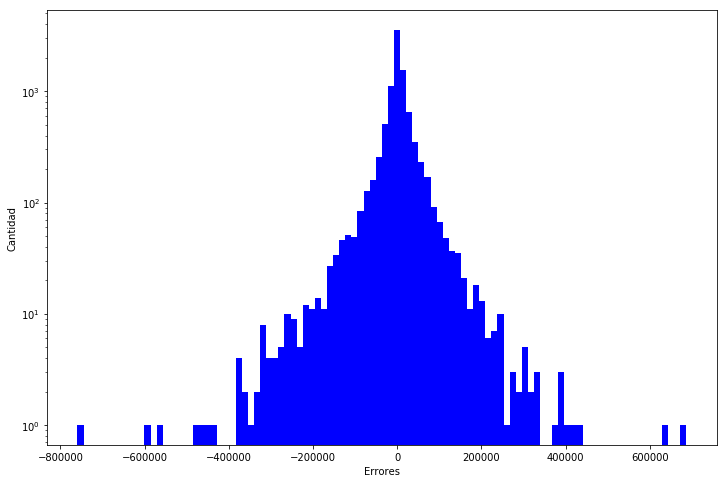

In [87]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()

###  Distribucion de precios

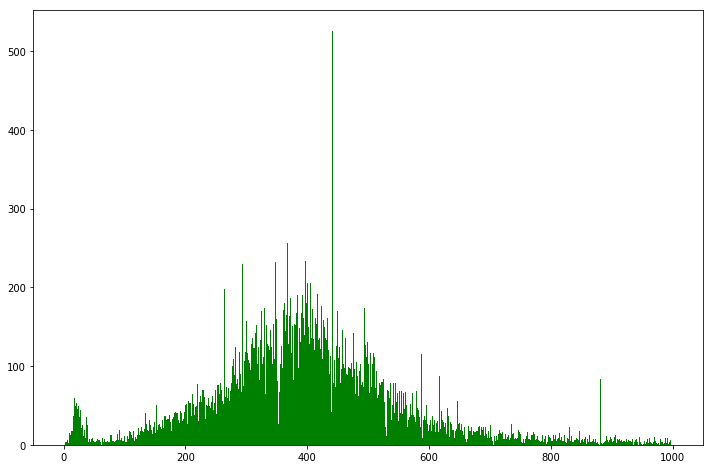

In [89]:
plt.figure(figsize=(12,8))
cant_buckets=1000
cantidad,rango = np.histogram(properati['price_usd_per_m2'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_usd_per_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
plt.hist(properati.categories_by_price,cant_buckets,facecolor='green')
plt.show()